# Rotation and correlated noise

The goal of this notebook is to quantify the correlations of noise between the image pixels due to its rotation.

## Import the pipeline

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../")
from spectractor import *

In [302]:
image = Image('./fits/trim_20170605_007.fits')

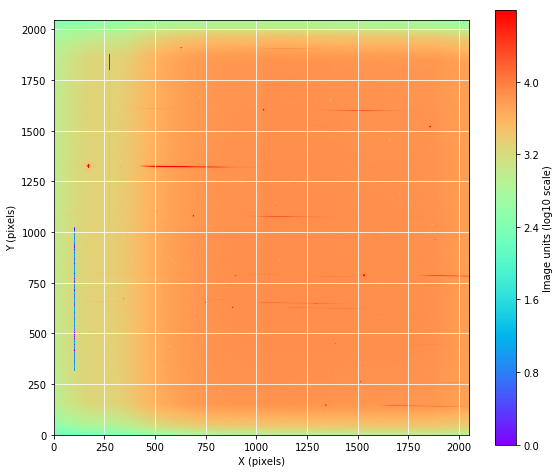

In [303]:
image.plot_image(scale="log10")

Truncate image to gain speedness:

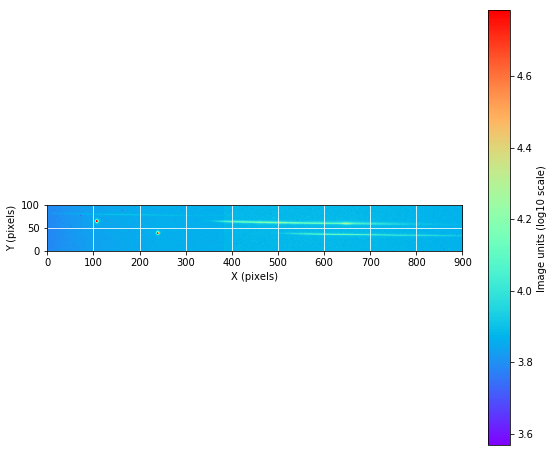

In [304]:
yguess = 640
xguess = 740
image.data=image.data[yguess-50:yguess+50,xguess-100:xguess+800]
image.stat_errors=image.stat_errors[yguess-50:yguess+50,xguess-100:xguess+800]
image.gain=image.gain[yguess-50:yguess+50,xguess-100:xguess+800]
image.plot_image(scale="log10")

## Compute random noise maps

First we compute random noise maps from the statistical error map computed on the above image. We stack n_samples noise maps to check if we recover the input variances and covariances.

In [295]:
def draw_noise_cholesky(image):
    '''The Cholesky metho to draw random pixel values
    from statistical error matrix is trivial here
    as pixel noise is not correlated.'''
    shape = image.stat_errors.shape
    std = image.stat_errors.flatten()
    r = np.random.standard_normal(std.size)
    noisy = r*std
    noisy = noisy.reshape(shape)
    return(noisy) 

def noisy_maps_std(noisy_maps):
    return np.std(noisy_maps,axis=0)

def plot_noise_diagnostics(image,std):
    fig, ax = plt.subplots(4,1,figsize=[12,4*3])
    im = ax[0].imshow(image,origin='lower')
    cb = plt.colorbar(im,ax=ax[0], orientation='horizontal')
    cb.set_label('Image noise std')
    im = ax[1].imshow(std,origin='lower')
    cb = plt.colorbar(im,ax=ax[1], orientation='horizontal')
    cb.set_label('Std in stacked noise maps')
    im = ax[2].imshow(np.abs(std-image),origin='lower')
    cb = plt.colorbar(im,ax=ax[2], orientation='horizontal')
    cb.set_label('Residuals (absolute value)')
    im = ax[3].imshow(np.abs(std-image)/image,origin='lower')
    cb = plt.colorbar(im,ax=ax[3], orientation='horizontal')
    cb.set_label('Residuals (normalized)')
    print 'Average normalized residuals: %.2f percent' % np.nanmean(100*np.abs(std-image)/image)
    plt.show()

In [265]:
n_samples = 100
noisy_maps = []
for i in range(n_samples):
    noisy_maps.append( draw_noise_cholesky(image) )

Now we compute the standard deviation for each pixels and we compare to the original noise map.

In [287]:
std = noisy_maps_std(noisy_maps)

Average normalized residuals: 5.68 percent


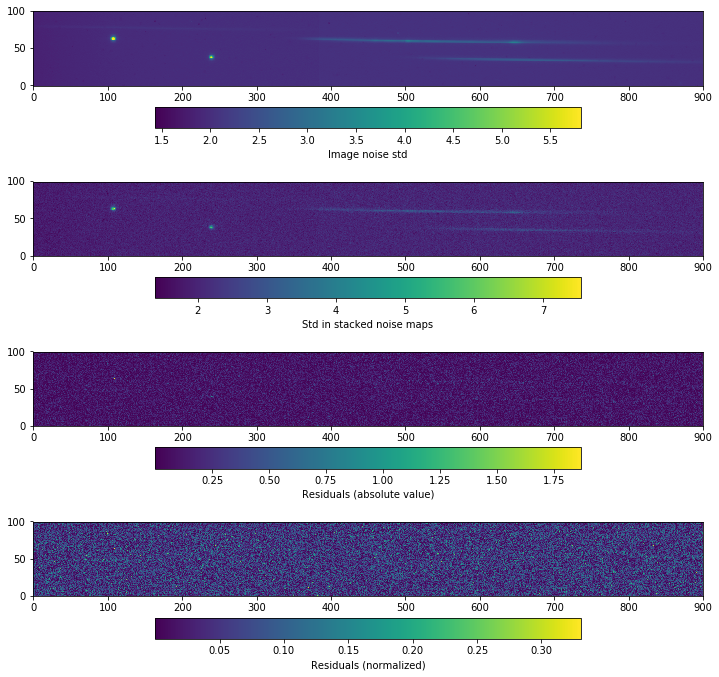

In [288]:
plot_noise_diagnostics(image.stat_errors,std)

n_samples = 100 is enough to get a residual map at 5% with respect to the original noise map.

Now we check that the noise is still uncorrelated between the pixels.

In [283]:
def noisy_maps_correlation(noisy_maps, lag=1, progressbar=True):
    shape = noisy_maps[0].shape
    Nx = shape[1]
    Ny = shape[0]
    n_samples = len(noisy_maps)
    # reshape the noisy_maps list
    noisy_maps = np.array(noisy_maps).T
    correlations = np.zeros(shape).T
    # progress bar..."
    if progressbar: print 'X index =',
    # remove the edges
    for i in range(lag,Nx-lag):
        if i%100==0 and progressbar: print '%d...' % i,
        for j in range(lag,Ny-lag):
            # extract the sub-cube around pixel i,j
            correlation_list = noisy_maps[i-lag:i+lag+1:lag,j-lag:j+lag+1:lag]
            corr = np.corrcoef(correlation_list.reshape((9,n_samples)))
            # compute the mean of the correlation matrix for pixel i,j
            # located at the center of the 9x9 correlation matrix
            correlations[i,j] = np.mean([corr[4,k] for k in range(9) if k!=4])
    # reshape the noisy_maps list to original shape
    noisy_maps = np.array(noisy_maps).T
    correlations = correlations.T
    return correlations

In [284]:
correlations = noisy_maps_correlation(noisy_maps,lag=1)
print correlations.shape
print correlations

X index = 100... 200... 300... 400... 500... 600... 700... 800... (100, 900)
[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.         -0.00589298  0.03917532 ..., -0.01863456  0.01562404  0.        ]
 [ 0.          0.01339675  0.01455639 ..., -0.01480359 -0.01610875  0.        ]
 ..., 
 [ 0.          0.00876574 -0.03323965 ...,  0.04856005  0.03305832  0.        ]
 [ 0.          0.01437254  0.00370546 ...,  0.03012796 -0.04142842  0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]


	Lag = 1 pixels: mean noise correlation coefficient between pixels: 0.00
	Lag = 2 pixels: mean noise correlation coefficient between pixels: 0.00
	Lag = 3 pixels: mean noise correlation coefficient between pixels: 0.00
	Lag = 5 pixels: mean noise correlation coefficient between pixels: -0.00
	Lag = 10 pixels: mean noise correlation coefficient between pixels: -0.00


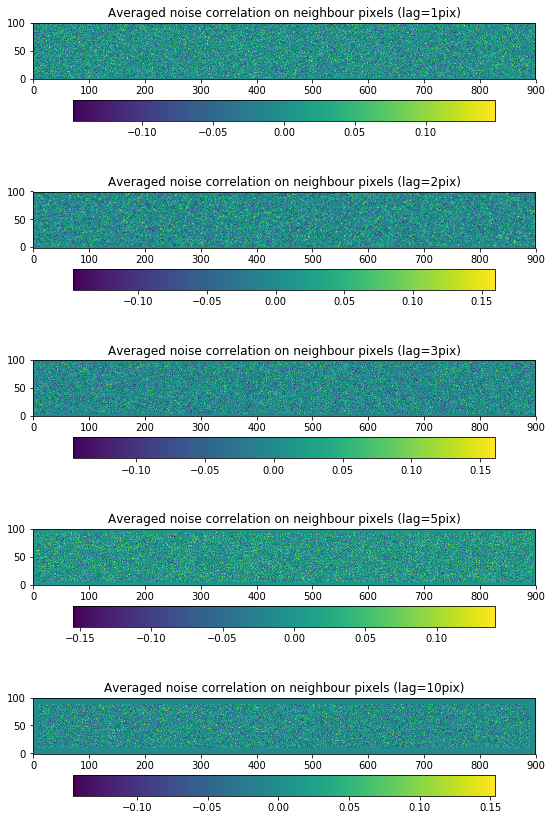

In [285]:
lags = [1,2,3,5,10]
fig, ax = plt.subplots(len(lags),1,figsize=[9,3*len(lags)])
correlations = []
for il,l in enumerate(lags):
    correlations.append(noisy_maps_correlation(noisy_maps,lag=l,progressbar=False))
    print 'Lag = %d pixels: mean noise correlation coefficient between pixels: %.2f'% (l,np.nanmean(correlations[-1]))
    im = ax[il].imshow(correlations[-1],origin='lower')
    cb = plt.colorbar(im,ax=ax[il], orientation='horizontal')
    ax[il].set_title('Averaged noise correlation on neighbour pixels (lag=%dpix)' % l)
plt.show()

After this regeneration of the noise maps, the noise is still uncorrelated as expected. Now we introduce a rotation of the images.

## Rotations and noise maps

Angle = 0.1 degree
Average normalized residuals: 60.74 percent


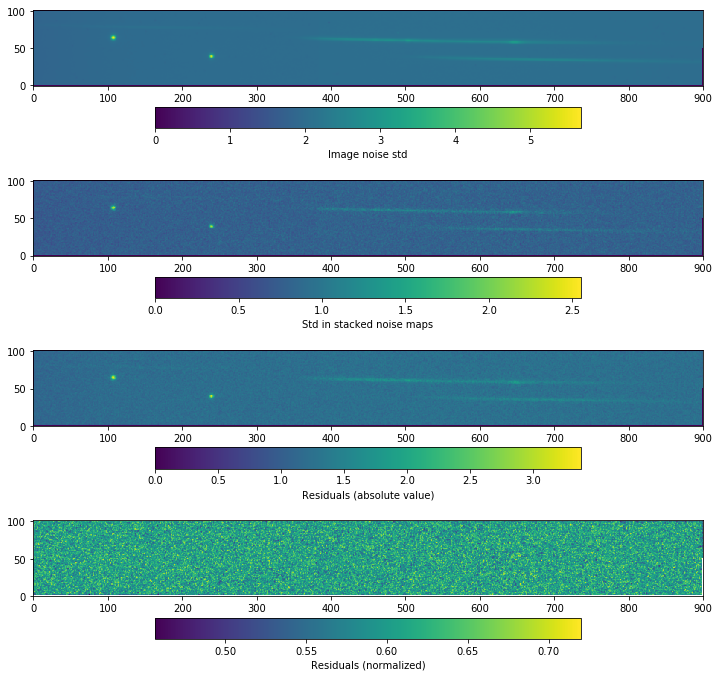

Angle = 0.2 degree
Average normalized residuals: 60.73 percent


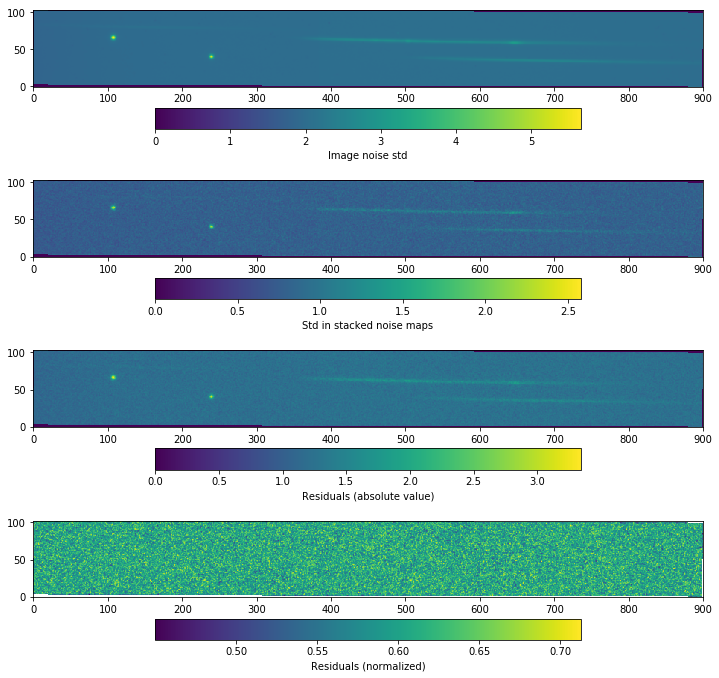

Angle = 0.5 degree
Average normalized residuals: 60.86 percent


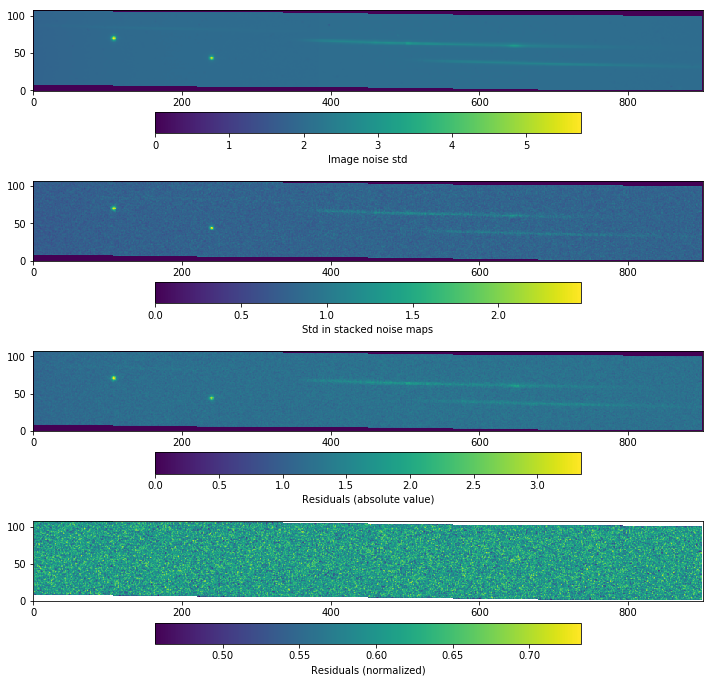

Angle = 1.0 degree
Average normalized residuals: 60.86 percent


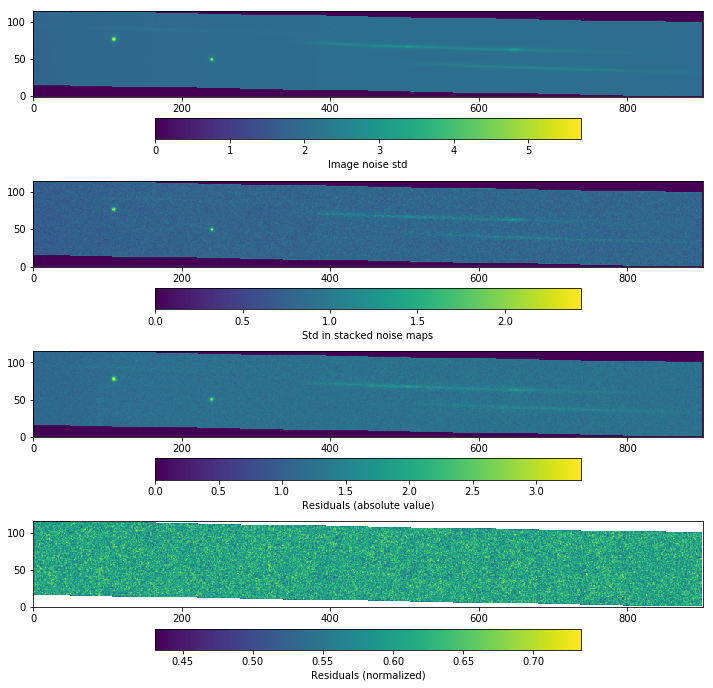

Angle = 2.0 degree
Average normalized residuals: 60.83 percent


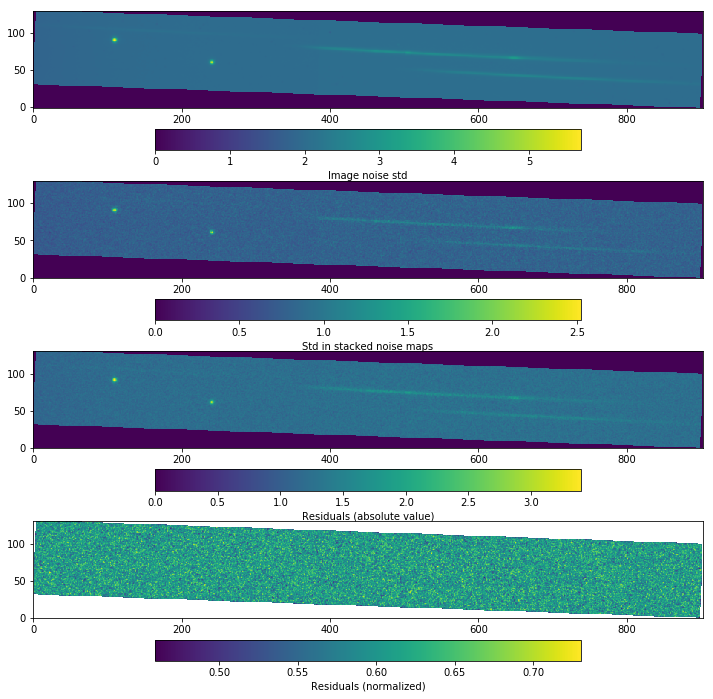

Angle = 5.0 degree
Average normalized residuals: 60.84 percent


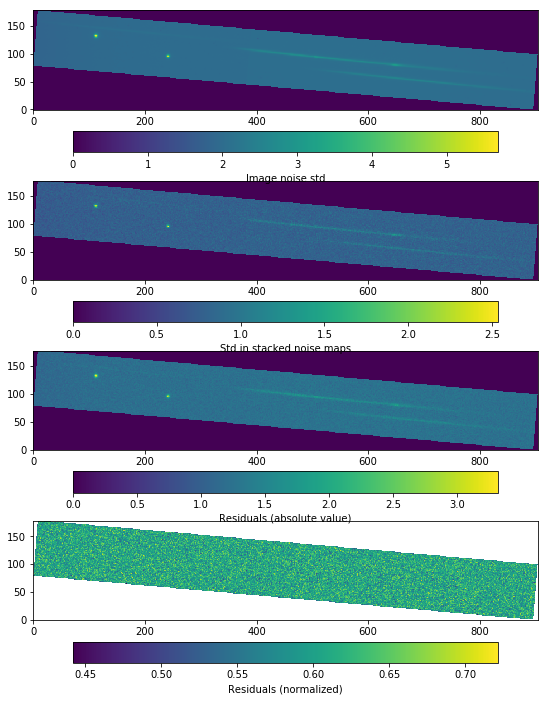

Angle = 10.0 degree
Average normalized residuals: 60.84 percent


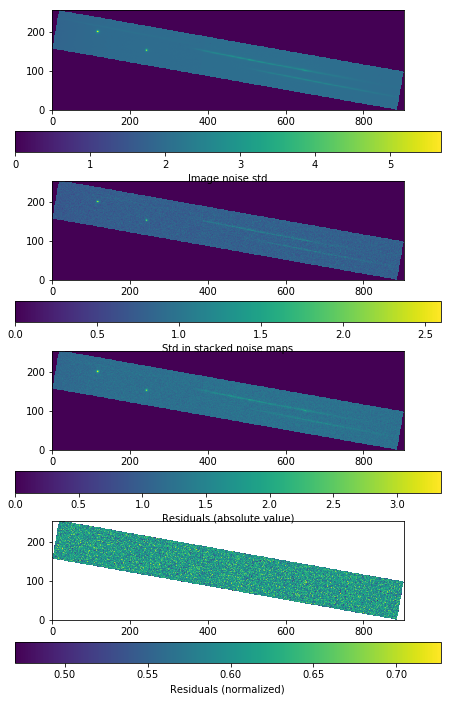

In [306]:
angles = [0.1,0.2,0.5,1,2,5,10]
for ia,angle in enumerate(angles):
    print 'Angle = %.1f degree' % angle
    rotated_noisy_maps = []
    for m in noisy_maps:
        rotated_noisy_maps.append(ndimage.interpolation.rotate(m,angle,prefilter=False,order=5))
    rot_std = noisy_maps_std(rotated_noisy_maps)
    rot_stat_errors = ndimage.interpolation.rotate(image.stat_errors,angle,prefilter=False,order=5)
    plot_noise_diagnostics(rot_stat_errors,rot_std)

## Rotations and noise correlation

Angle = 0.1 degree
	Lag = 1 pixels: mean noise correlation coefficient between pixels: 0.49
	Lag = 2 pixels: mean noise correlation coefficient between pixels: 0.08
	Lag = 3 pixels: mean noise correlation coefficient between pixels: 0.00
	Lag = 5 pixels: mean noise correlation coefficient between pixels: -0.00
Angle = 0.2 degree
	Lag = 1 pixels: mean noise correlation coefficient between pixels: 0.48
	Lag = 2 pixels: mean noise correlation coefficient between pixels: 0.08
	Lag = 3 pixels: mean noise correlation coefficient between pixels: 0.00
	Lag = 5 pixels: mean noise correlation coefficient between pixels: -0.00
Angle = 0.5 degree
	Lag = 1 pixels: mean noise correlation coefficient between pixels: 0.49
	Lag = 2 pixels: mean noise correlation coefficient between pixels: 0.08
	Lag = 3 pixels: mean noise correlation coefficient between pixels: 0.00
	Lag = 5 pixels: mean noise correlation coefficient between pixels: -0.00
Angle = 1.0 degree
	Lag = 1 pixels: mean noise correlation coeff

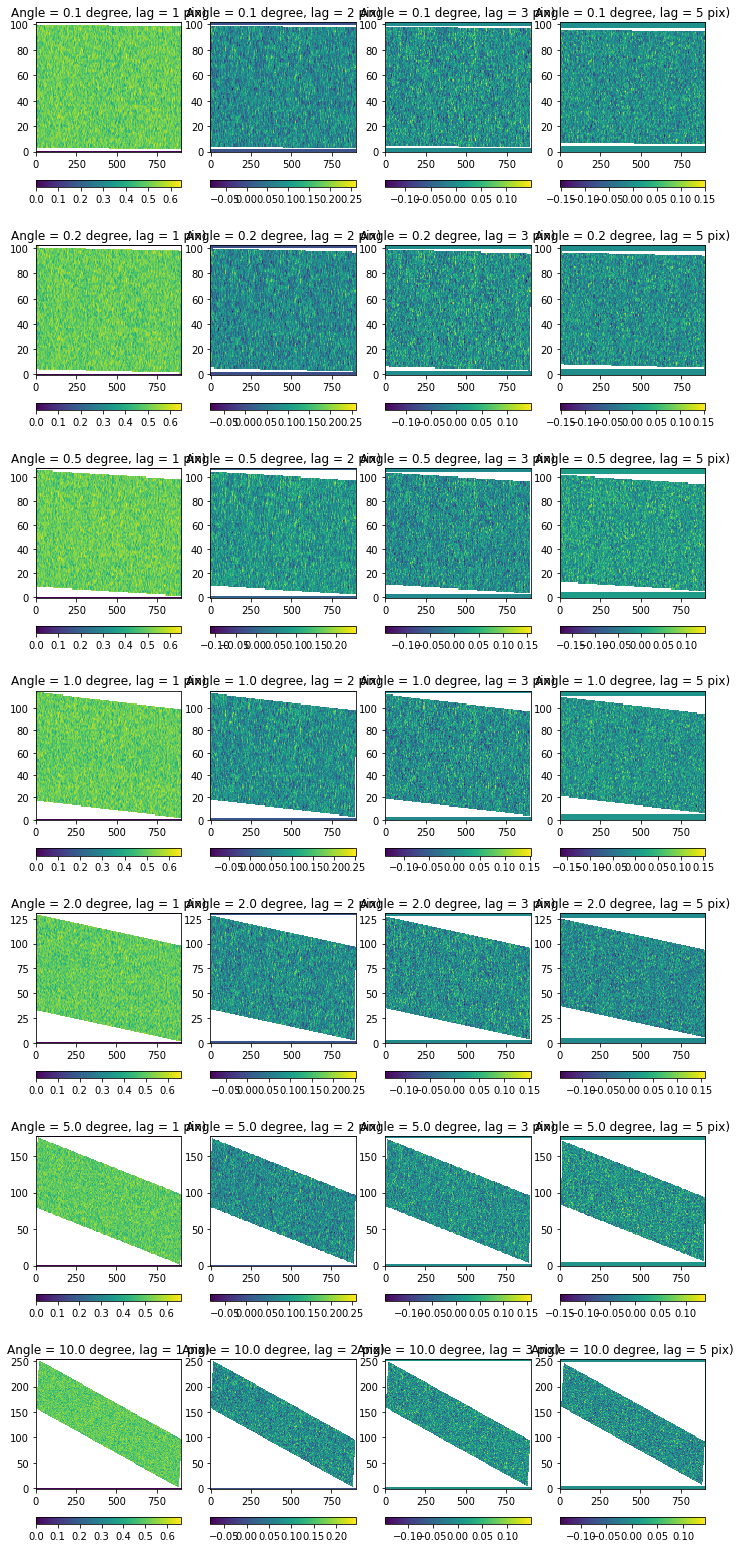

In [282]:
angles = [0.1,0.2,0.5,1,2,5,10]
lags = [1,2,3]
fig, ax = plt.subplots(len(angles),len(lags),figsize=[12,4*len(angles)])
correlations = []
for ia,angle in enumerate(angles):
    print 'Angle = %.1f degree' % angle
    rotated_noisy_maps = []
    for m in noisy_maps:
        rotated_noisy_maps.append(ndimage.interpolation.rotate(m,angle,prefilter=False,order=5))
    for il,l in enumerate(lags):
        correlations.append(noisy_maps_correlation(rotated_noisy_maps,lag=l,progressbar=False))
        print '\tLag = %d pixels: mean noise correlation coefficient between pixels: %.2f'% (l,np.nanmean(correlations[-1]))
        im = ax[ia,il].imshow(correlations[-1],origin='lower',aspect="auto")
        cb = plt.colorbar(im,ax=ax[ia,il], orientation='horizontal')
        ax[ia,il].set_title('Angle = %.1f degree, lag = %d pix)' % (angle,l))
plt.show()